In [27]:
import gdown
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [7]:
file_id = "1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq"
output_file = "train_data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
To: /content/train_data.zip
100%|██████████| 173M/173M [00:01<00:00, 109MB/s]


'train_data.zip'

In [8]:
file_id = "1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6"
output_file = "test_data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6
To: /content/test_data.zip
100%|██████████| 73.0M/73.0M [00:00<00:00, 88.5MB/s]


'test_data.zip'

In [9]:
!unzip 'train_data.zip'
!unzip 'test_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train_data/7/cb9e3cee1ecf49a7de4ae317f7311c61b27c36cf_1626090054.jpg  
  inflating: train_data/7/59bbc079bd5f0ff4d741a55eef5b36feafc1646e_1625999408.jpg  
  inflating: train_data/7/3011d1467ab8a231278a3d99612ade65e29c3fb1_1630165516.jpg  
  inflating: train_data/7/8673dadd0c8a3b58559b7bc3084a5cb6841f43d9_1630502374.jpg  
  inflating: train_data/7/1238f2c8768b56a88e22eaf91ba34e465337b2f8_1614428196.jpg  
  inflating: train_data/7/19aad5b964ebf26584dbba29e4fc1681693dc090_1630133516.jpg  
  inflating: train_data/7/2aaec0e6e0f8b1c8042e650b8cffa1d60092a04c_1622395447.jpg  
  inflating: train_data/7/516e271a1079cc04a933ebe525a352b44d7f7b1b_1614377385.jpg  
  inflating: train_data/7/f62cd1e5c48d4635f6018ff76c946375fb13b2f3_1626803573.jpg  
  inflating: train_data/7/0171d0208beed9f0094d778764d9bf60e5a5f923_1629921532.jpg  
  inflating: train_data/7/53d440c30fb32f343f97b47b0277c6e20fbb2948_1628697714.jpg  
  inflating: train_data/7

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "train_data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9990 files belonging to 10 classes.
Using 7992 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "train_data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9990 files belonging to 10 classes.
Using 1998 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


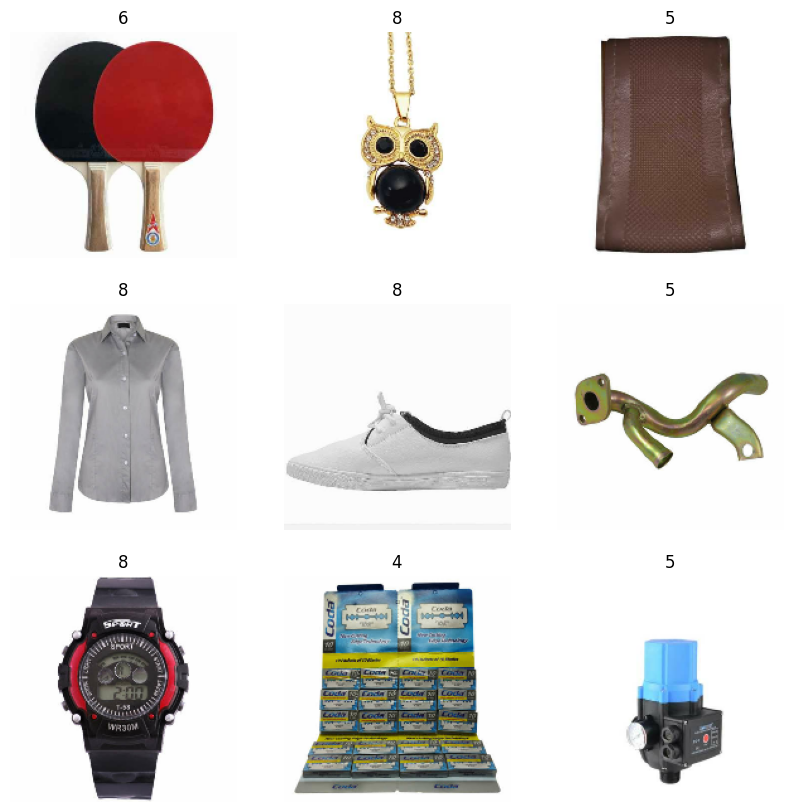

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [29]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [30]:
for layer in base_model.layers:
   layer.trainable = False


In [31]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 65/250 [======>.......................] - ETA: 7:09 - loss: 29.1600 - accuracy: 0.1183